In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

# Directory with our training non-violation pictures
train_nonviolation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Testing_data_2/Non_violation') 

# Directory with our training violation pictures
train_violation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Testing_data_2/Violation') 

# Directory with our validation non-violation pictures
valid_nonviolation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Validation/Non_violation') 

# Directory with our validation violation pictures
valid_violation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Validation/Violation')

In [ ]:
train_nonviolation_names = [f for f in os.listdir(train_nonviolation_dir)]

print(train_nonviolation_names[:10])

train_violation_names = [f for f in os.listdir(train_violation_dir)]
print(train_violation_names[:10])

validation_nonviolation_hames = [f for f in os.listdir(valid_nonviolation_dir)]
print(validation_nonviolation_hames[:10])

validation_violation_names = [f for f in os.listdir(valid_violation_dir)]
print(validation_violation_names[:10])

print()

print('total training nonviolation images:', len(os.listdir(train_nonviolation_dir)))
print('total training violation images:', len(os.listdir(train_violation_dir)))
print('total validation nonviolation images:', len(os.listdir(valid_nonviolation_dir)))
print('total validation violation images:', len(os.listdir(valid_violation_dir)))

['Copy of _0_1297902 (1).jpg', 'Copy of _0_1297902.jpg', 'Copy of _0_993035.jpg', 'Copy of _0_2264699.jpg', 'Copy of _9_1167519.jpg', 'Copy of _2_4334496.jpg', 'Copy of _2_2431837.jpg', 'Copy of _2_2462297.jpg', 'Copy of _2_3204331.jpg', 'Copy of _2_4004520.jpg']
['mg28.jpg', 'photo16.jpg', 'image34.jpg', 'mg7.jpg', 'mg17 4.16.14 PM.jpg', 'photo12.jpg', 'mg30.jpg', 'image9.jpeg', 'mg11.jpg', 'photo13.jpeg']
['Copy of _0_6460006.jpg', 'Copy of _0_9377298.jpg', 'Copy of _0_7089029.jpg', 'Copy of _0_6874368.jpg', 'Copy of _1_8272983.jpg', 'Copy of _1_6872858.jpg', 'Copy of _1_6386370.jpg', 'Copy of _1_3090079.jpg', 'Copy of _3_3168220.jpg', 'Copy of _3_2980678.jpg']
['image48.jpg', 'image47.jpg', 'mg3.jpg', 'image51.jpg', 'image40.jpg', 'image43.jpg', 'image41.jpg', 'image44.jpg', 'git17.jpeg', 'git23.jpeg']

total training nonviolation images: 92
total training violation images: 95
total validation nonviolation images: 36
total validation violation images: 40


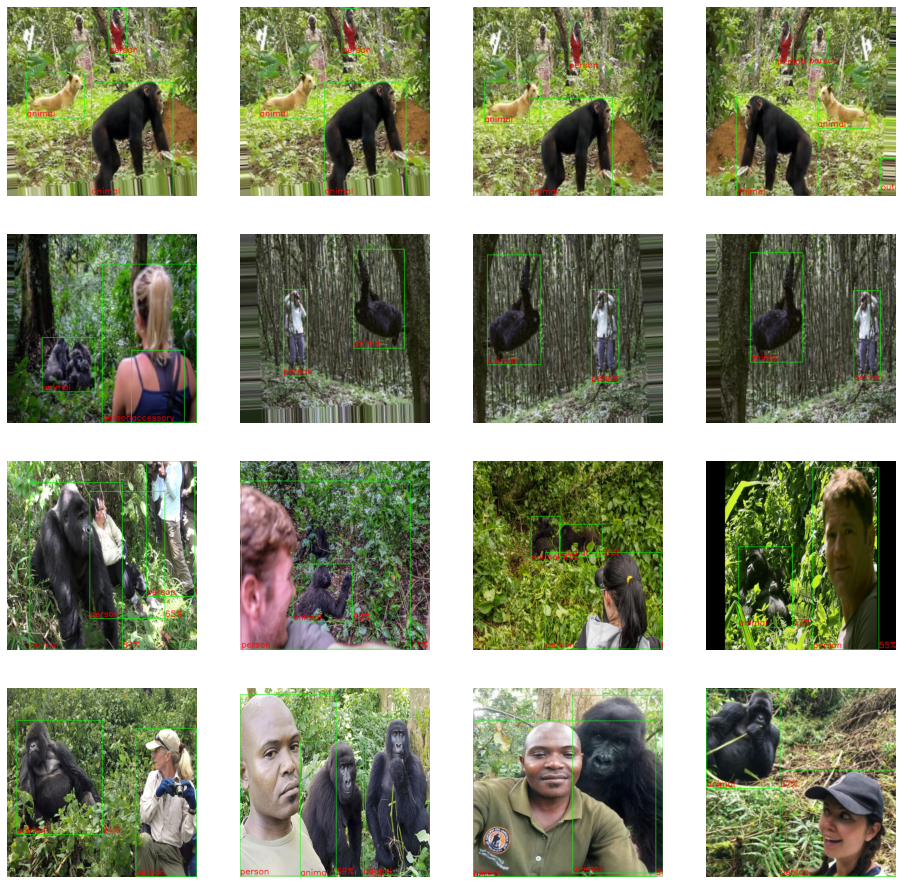

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_nonviolation_pic = [os.path.join(train_nonviolation_dir, fname) 
                for fname in train_nonviolation_names[pic_index-8:pic_index]]
next_violation_pic = [os.path.join(train_violation_dir, fname) 
                for fname in train_violation_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_nonviolation_pic + next_violation_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.densenet import DenseNet169

In [ ]:
dense_model = DenseNet169(input_shape = (200, 200, 3), 
                                weights='imagenet',
                                include_top = False)

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
for layer in dense_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.models import Model

x = tf.keras.layers.Flatten()(dense_model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = dense_model.input, outputs = x)

model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(lr=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory with our training pictures
train_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Testing_data_2') 

# Directory with our validation pictures
valid_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Gorillas_Validation') 

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,  # source directory for training images
        classes = ['Non_violation', 'Violation'],
        target_size = (200, 200),  # Images resized to 200x200
        batch_size = 32, #128
        # Use binary labels
        class_mode = 'binary')

# Flow validation images in batches of 16 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        valid_dir,  # source directory for training images
        classes = ['Non_violation', 'Violation'],
        target_size = (200, 200),  # Images resized to 200x200
        batch_size = 16, #32
        # Use binary labels
        class_mode = 'binary',
        shuffle = False)

Found 187 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
history = model.fit(train_generator,
      # steps_per_epoch=9,  
      epochs = 10,
      verbose = 1,
      validation_data = validation_generator)

Epoch 1/10
6/6 [==============================] - 123s 19s/step - loss: 6.2303 - accuracy: 0.6310 - val_loss: 0.5889 - val_accuracy: 0.8684
Epoch 2/10
6/6 [==============================] - 33s 6s/step - loss: 0.1713 - accuracy: 0.9519 - val_loss: 0.6207 - val_accuracy: 0.8947
Epoch 3/10
6/6 [==============================] - 33s 6s/step - loss: 0.0324 - accuracy: 0.9840 - val_loss: 0.5064 - val_accuracy: 0.9079
Epoch 4/10
6/6 [==============================] - 33s 6s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3296 - val_accuracy: 0.9342
Epoch 5/10
6/6 [==============================] - 33s 6s/step - loss: 3.1825e-04 - accuracy: 1.0000 - val_loss: 0.3274 - val_accuracy: 0.9342
Epoch 6/10
6/6 [==============================] - 33s 6s/step - loss: 2.8278e-04 - accuracy: 1.0000 - val_loss: 0.3246 - val_accuracy: 0.9342
Epoch 7/10
6/6 [==============================] - 33s 6s/step - loss: 2.5652e-04 - accuracy: 1.0000 - val_loss: 0.3250 - val_accuracy: 0.9342
Epoch 8/10
6/6 [====

In [ ]:
test_dir = os.path.join('gdrive/MyDrive/Data/Data_collection2/other_animals')
test_image_generator = ImageDataGenerator(rescale=1./255)


# Testing on all violation images
test_data_gen = test_image_generator.flow_from_directory(
        directory=test_dir,
        classes=['Violation'], 
        target_size=(200, 200),
        batch_size=1,
        shuffle=False)

pred = model.predict(test_data_gen)
len = pred.shape[0]
probabilities = [1 if x > 0.5 else 0 for x in pred] # 0 means correct
print("Violations:", probabilities) # violations checked
print('Accuracy: ', sum(probabilities)/len)

y_true = [1 for i in range(len)]

print()

# Testing on all non-violation images
test_data_gen = test_image_generator.flow_from_directory(
        directory=test_dir,
        classes=['Non_violation'], 
        target_size=(200, 200),
        batch_size=1,
        # class_mode = 'binary'
        shuffle=False)

pred = model.predict(test_data_gen)
len = pred.shape[0]
probabilities2 = [0 if x > 0.5 else 1 for x in pred] # 1 means correct
print("Non_violations:", probabilities2) # non-violation checked
correct = 0
for i in range(len):
    if probabilities2[i]==0: correct+=1
y_true += [0 for i in range(len)]
print('Accuracy: ', correct/len)

Found 567 images belonging to 1 classes.
Non_violations: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Overall Accuracy: 0.5321955003878976
F1 score: 0.5906313645621182
Recall: 0.6024930747922438
Precision: 0.5792276964047937


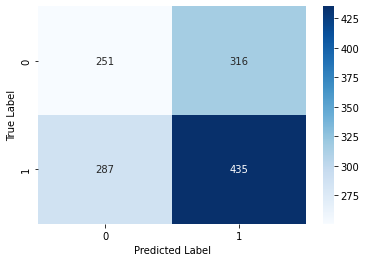

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

probs = probabilities + probabilities2

cm = confusion_matrix(y_true, probs)
map = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues')
map.set(xlabel='Predicted Label', ylabel='True Label')

print ('Overall Accuracy:', accuracy_score(y_true, probs))
print ('F1 score:', f1_score(y_true, probs))
print ('Recall:', recall_score(y_true, probs))
print ('Precision:', precision_score(y_true, probs))